In [2]:
!pip install PyDictionary

  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1273 sha256=d4050c9d60973de0888fb066ebbd28340fc7cbfa8a4c6899f7ab2abe0ad21c3d
  Stored in directory: c:\users\mayan\appdata\local\pip\cache\wheels\75\78\21\68b124549c9bdc94f822c02fb9aa3578a669843f9767776bca
  Created wheel for goslate: filename=goslate-1.5.2-py3-none-any.whl size=11403 sha256=42ebbb694035333f231ee11327cdb66954d9d7f82bd6782aea2e181a48f4b0c4
  Stored in directory: c:\users\mayan\appdata\local\pip\cache\wheels\6a\ef\a4\262a5f7c9dc6fd6ac71a06df4e787511992de897721bcb5587
  Created wheel for futures: filename=futures-3.0.5-py3-none-any.whl size=14080 sha256=6e84c63ce452574c39f4628fc9e563f88777dc9e5defd76bf2f19e7220a6a121
  Stored in directory: c:\users\mayan\appdata\local\pip\cache\wheels\8b\63\2a\b26b5d293191299916236972878f61ed040ae952349024bb56
Successfully built bs4 goslate futures


In [162]:
! pip install pytrec-eval-terrier

### Rough Work Flow

- Need all words possible in py_dict -> used nltk WN
- sub sample all possible to a list of value # candidate selection -> first char of word
- solve for list of value multiproc
- code med algo -> prof provided
- compute s@k -> wrapped around py_terrier

### Importing Packages

In [3]:
from PyDictionary import PyDictionary
import numpy as np

In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mayan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [27]:
from nltk.corpus import wordnet as wn

In [29]:
all_words = [word for word in wn.words()]

In [316]:
print(len(all_words))

147306


In [317]:
all_words_alp = [word for word in wn.words() if word.isalpha()]

In [319]:
print(len(all_words_alp))

77503


### already optimized code for med provided

In [121]:
# https://blog.paperspace.com/implementing-levenshtein-distance-word-autocomplete-autocorrect/
# Ahmed Fawzy Gad
# AI/ML engineer and a talented technical writer who authors 4 scientific books and more than 80 articles and tutorials. https://www.linkedin.com/in/ahmedfgad

import numpy
def levenshtein(token1, token2):
    distances = numpy.zeros((len(token1) + 1, len(token2) + 1))
    for t1 in range(len(token1) + 1): distances[t1][0] = t1
    for t2 in range(len(token2) + 1): distances[0][t2] = t2
    a = 0; b = 0; c = 0

    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
              a = distances[t1][t2 - 1]
              b = distances[t1 - 1][t2]
              c = distances[t1 - 1][t2 - 1]

              if (a <= b and a <= c): distances[t1][t2] = a + 1
              elif (b <= a and b <= c): distances[t1][t2] = b + 1
              else: 
                if (token1[t1 - 1] == token2[t2 - 1]): distances[t1][t2] = c
                else: distances[t1][t2] = c + 2

#     print_matrix(distances, len(token1), len(token2))
    return distances[len(token1)][len(token2)]

def print_matrix(distances, token1Length, token2Length):
    for t1 in range(token1Length + 1):
        for t2 in range(token2Length + 1):
            print(str(int(distances[t1][t2])).zfill(2), end=" ")
        print()

levenshtein("crin", "ction")


3.0

In [36]:
levenshtein("appli", "ction")

00 01 02 03 04 05 
01 02 03 04 05 06 
02 03 04 05 06 07 
03 04 05 06 07 08 
04 05 06 07 08 09 
05 06 07 06 07 08 


8.0

### try loading spelling error data 

In [43]:
with open("data/0643/SHEFFIELDDAT.643", "r") as fp:
    data = fp.read()

In [58]:
import pandas as pd

typo = []
crct = []

for line in data.split("\n"):
    if line.strip():
        t_ = re.split("\s+", line)
        crc_, typ_ = t_[0], t_[1]
        typo.append(typ_)
        crct.append(crc_)

df = pd.DataFrame({"typo":typo, "crct":crct})
    

In [350]:
df.shape

(384, 6)

### Transform spelling error data to Dataframem

In [60]:
df.head()

,typo,crct
0,ABILTY,ABILITY
1,ABRAOD,ABROAD
2,ACEDEMIC,ACADEMIC
3,ACCESION,ACCESSION
4,ACCOMODATE,ACCOMMODATE


In [62]:
all_words[:5]

['.22-caliber', '.22-calibre', '.22_caliber', '.22_calibre', '.38-caliber']

### enabling fetching vocab -WN by first char

In [71]:
def create_dict(all_words):
    allWD = {}
    for w in all_words:
        fc = w[0]
        if fc not in allWD:
            print(fc, w)
            allWD[fc] = []
        allWD[fc].append(w)
    return allWD
allWD = create_dict(all_words)

def fetch_allw_by_c(char, alpha=False):
    if alpha:
        return [w for w in allWD[char] if w.isalpha()] # can create other dictionary to fast lookup
    return allWD[char]

. .22-caliber
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
a a-ok
b babelike
c c
d d
e each
f fab
g gabby
h h-shaped
i i
j jacksonian
k k
l l
m m
n n-th
o o.k.
p p.m.
q qabalistic
r r.c.
s s-shaped
t t-shaped
u u
v v
w w-shaped
x x
y y-shaped
z zaftig
' 'tween


In [73]:
print(len(fetch_allw_by_c('a', alpha=False)))
print(len(fetch_allw_by_c('a', alpha=True)))

10095
5980


### Candidate slection using first char - No multi thread

In [106]:
# global wn and med algo to fetch 
def fetch_topk(typo):
    # fetch_candidates
    
    # fetch words only starting with first char from wn
    all_c = fetch_allw_by_c(typo[0], alpha=True)[:5000]
    print(all_c[-1])
    print("discuss" in all_c)
    # multi_proc med calc
    
    all_c_sc = [levenshtein(typo, c) for c in all_c]
    from operator import itemgetter
    data = zip(all_c, all_c_sc)
    data = sorted(data,key=itemgetter(1))
    print(data[:8])

    
    # top k based on response

In [108]:
fetch_topk("diskus")

dynamize
True
[('discus', 2.0), ('disk', 2.0), ('disuse', 2.0), ('diss', 2.0), ('disused', 3.0), ('dipus', 3.0), ('dis', 3.0), ('disgust', 3.0)]


#### Levenshtein to support multi-thread

In [143]:
# https://blog.paperspace.com/implementing-levenshtein-distance-word-autocomplete-autocorrect/
# Ahmed Fawzy Gad
# AI/ML engineer and a talented technical writer who authors 4 scientific books and more than 80 articles and tutorials. https://www.linkedin.com/in/ahmedfgad

import numpy
def levenshtein_mt(token):
    token1 = token[0]
    token2 = token[1]
    distances = numpy.zeros((len(token1) + 1, len(token2) + 1))
    for t1 in range(len(token1) + 1): distances[t1][0] = t1
    for t2 in range(len(token2) + 1): distances[0][t2] = t2
    a = 0; b = 0; c = 0

    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
              a = distances[t1][t2 - 1]
              b = distances[t1 - 1][t2]
              c = distances[t1 - 1][t2 - 1]

              if (a <= b and a <= c): distances[t1][t2] = a + 1
              elif (b <= a and b <= c): distances[t1][t2] = b + 1
              else: 
                if (token1[t1 - 1] == token2[t2 - 1]): distances[t1][t2] = c
                else: distances[t1][t2] = c + 2

#     print_matrix(distances, len(token1), len(token2))
    return distances[len(token1)][len(token2)], abs(len(token1) - len(token2))


### Candidate Selection and MED Calculation using Multi-thread

In [353]:
# multi_proc
from multiprocessing.dummy import Pool as ThreadPool
import itertools
# global wn and med algo to fetch 
def fetch_topk_mt(typo, k=8):
    
    # fetch_candidates
    
    # fetch words only starting with first char from wn
    if typo.isalpha():
        all_c = fetch_allw_by_c(typo[0], alpha=True)
    else:
        all_c = fetch_allw_by_c(typo[0], alpha=False)
    
#     print(len(all_c))
#     print("discuss" in all_c)
    
    # multi_proc med calc
    # Make the Pool of workers
    pool = ThreadPool(100)
    all_c_sc = pool.map(levenshtein_mt, zip(itertools.repeat(typo), all_c))

    # Close the pool and wait for the work to finish
    pool.close()
    pool.join()
    from operator import itemgetter
    data = zip(all_c, all_c_sc)
    data = sorted(data,key=itemgetter(1))
#     print(data[:k])
    # any other logc for elimination or modify ranking

    
    # top k based on response
    return [w for w, s in data[:k]]

In [347]:
fetch_topk_mt("aplikation")

['application',
 'alienation',
 'aspiration',
 'ablation',
 'alkapton',
 'aviation',
 'abolition',
 'acclimation']

### Computing success at top k  using pytrec and custom wrapper

In [354]:
# what format py_trec takes in put//
def compute_avgsk(row):
#     print(row, type(row))
    sug = fetch_topk_mt(row["typo"].lower(), k=10)
    qrel = {'q1':{f'{row["crct"].lower()}':10}}
    sug_ = ";".join(sug)
    evaluator = pytrec_eval.RelevanceEvaluator(qrel, {'ndcg'})
    
    run1 = {'q1':{f'{sug[0]}':10}}
    v1 = evaluator.evaluate(run1)["q1"]["ndcg"]
    
    run5 = {'q1':{k:10-ix for ix, k in enumerate(sug[:5])}}
    v5 = evaluator.evaluate(run5)["q1"]["ndcg"]
    
    run10 = {'q1':{k:10-ix for ix, k in enumerate(sug[:10])}}
    v10 = evaluator.evaluate(run10)["q1"]["ndcg"]
    
    return (sug_, v1, v5, v10, (v1+v5+v10)/3)

In [356]:
t = df.apply(compute_avgsk, axis=1)

In [360]:
df[["sug", "s1", "s5", "s10", "savg"]] = pd.DataFrame(t.tolist(), index= t.index)

In [379]:
df.tail() # should have kept suggestion

,typo,crct,s1,s5,s10,savg,sug
379,WHIC,WHICH,0.0,0.0,0.000000,0.000000,whig;whim;whin;whip;whir;whit;whiz;wick;wi;whiny
380,WIIL,WILL,0.0,0.0,0.333333,0.111111,wild;wily;wail;weil;wifi;wile;will;wilt;wi;wei
381,WONDRFUL,WONDERFUL,1.0,1.0,1.000000,1.000000,wonderful;wonderfully;wondrous;worthful;wrongf...
382,WORHT,WORTH,0.0,0.5,0.500000,0.333333,wort;worst;worth;worn;worthy;wart;whit;wont;wo...
383,WOULS,WOULD,0.0,0.0,0.000000,0.000000,woeful;wold;wolf;wool;wouk;wuss;waul;wu;welsh;...


### Plotting success at top k using histogram

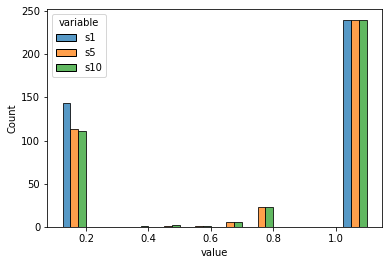

In [375]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# make dataframe
df2 = df[["s1", "s5", "s10"]].copy(deep=True)
# plot melted dataframe in a single command
his = sns.histplot(df2.melt(), x='value', hue='variable',
             multiple='dodge', shrink=.75, bins=10);

In [376]:
fig = his.get_figure()
fig.savefig("out.png") 